In [1]:
import matplotlib as mpl
from joblib import Parallel, delayed
import tqdm
from scipy.optimize import curve_fit
import os
import pandas as pd
from collections import OrderedDict
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append('../scales_project/')
from utils import utils
from utils import scale_by_scale_optim
from utils import scale_fitter_no_grid
from utils import evaluate
from utils import simulate_EPR


#MY SETUP FOR MATPLOTLIB
def setup_mpl():
    mpl.rc('font', size=7)
    mpl.rcParams['legend.fontsize'] = 'small'
    mpl.rcParams['legend.fontsize'] = 'small'
    mpl.rcParams['xtick.labelsize'] = 'small'
    mpl.rcParams['ytick.labelsize'] = 'small'
    mpl.rcParams['font.family']='Helvetica 55 Roman'
    mpl.rcParams['lines.linewidth'] = 1
    mpl.rcParams['xtick.major.width'] = 2/3.
    mpl.rcParams['ytick.major.width'] = 2/3.
    mpl.rcParams['xtick.minor.width'] = 2/3.
    mpl.rcParams['ytick.minor.width'] = 2/3.
    mpl.rcParams['xtick.major.size'] = 3
    mpl.rcParams['ytick.major.size'] = 3
    mpl.rcParams['xtick.minor.size'] = 1.5
    mpl.rcParams['ytick.minor.size'] = 1.5
    mpl.rcParams['axes.linewidth'] = 2/3.
    mpl.rcParams['ytick.direction'] = 'in'
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['xtick.top']=True
    mpl.rcParams['ytick.right']=True
    mpl.rcParams['mathtext.default']='regular'
    mpl.rcParams['xtick.major.pad']='2.3'
    mpl.rcParams['ytick.major.pad']='2.3'
    mpl.rcParams['axes.labelpad']= 2
    mpl.rcParams['figure.dpi'] = 400
    mpl.rcParams['svg.fonttype'] = "none"
    alpha = 0.6
    to_rgba = mpl.colors.ColorConverter().to_rgba
setup_mpl()



In [2]:
BINS_DR = np.logspace(1,7,40)

In [3]:
properties_testing = np.load("./modelling/properties_testing.npy", allow_pickle=True)


In [4]:
props = np.load("./modelling/properties_synthetic_data.npy", allow_pickle=True)
errs = np.load("./modelling/errors_synthetic_data.npy", allow_pickle=True)

In [5]:
labels = ['epr','container','m_epr','d_epr','recency_epr']

In [6]:
###PLOT RADIS OF GYRATION

def plot_radius_of_gyration(ax,
                            props,
                            errs,
                            properties,plot_every=2):
    x = range(1,51)[::plot_every]
    data_rg = np.nanmedian([list(i[1])+[np.nan]*(50-len(i[1])) for n,i in enumerate(properties)],axis = 0)[::plot_every]
    ax.plot(x,data_rg,color = 'k',marker='.',markersize=4)

    rgs = []
    errs1 = []
    errs2 = []
    for p,err_p in zip(props,
                       errs):

        rg = np.nanmedian([list(i[1])+[np.nan]*(50-len(i[1])) for n,i in enumerate(p) if len(p[n][1])>0],axis = 0)
        rg_err1 = np.nanpercentile([list(i[1])+[np.nan]*(50-len(i[1])) for n,i in enumerate(p) if len(err_p[n][1])>0],25, axis = 0)
        rg_err2 = np.nanpercentile([list(i[1])+[np.nan]*(50-len(i[2])) for n,i in enumerate(p) if len(err_p[n][2])>0],75, axis = 0)

        g1 = ax.plot(x,
                     rg[::plot_every])
        
        ax.fill_between(x,
                        rg_err1[::plot_every],
                        rg_err2[::plot_every],alpha=0.5,color = g1[0].get_color())
        rgs.append(rg[::plot_every])
        errs1.append(rg_err1[::plot_every])
        errs2.append(rg_err2[::plot_every])

    #ax.set_yscale('log')
    ax.set_xlabel('number of displacements')
    ax.set_ylabel('radius \n of gyration (m)')
    return x, data_rg, rgs, errs1, errs2
    
    
 ###PLOT DISTRIBUTION OF DISPLACEMENTS
def plot_distr_displacements(ax,
                             props,
                             errs,
                             properties,):
    e = BINS_DR
    x = e[:-1]
    y = np.nanmean([i[0] for n,i in enumerate(properties) if len(i[0])>0],axis=0)
    ax.loglog(x,
              y,color = 'k',marker='.', markersize =4)

    errs_1 = []
    pdfs = []
    for p,err_p in zip(props,errs):
        pdf = np.nanmean([i[0] for i in p if len(i[0])>0],axis = 0)
        pdf_err1 = np.nanstd([i[0] for i in p if len(i[0])>0],axis = 0)

        g1 = ax.loglog(x,
                       pdf)
        ax.fill_between(x,
                        pdf-pdf_err1,pdf+pdf_err1,alpha = 0.5,color = g1[0].get_color())
        pdfs.append(pdf)
        errs_1.append(pdf_err1)

    ax.set_yscale('log')
    ax.set_xlabel('displacement (m)')
    ax.set_ylabel('probability')
    return x, y , pdfs, errs_1
    
    
#PLOT FREQUENCY RANK
def plot_frequency_rank(ax,
                        props,
                        errs,
                        properties, N_max=42,plot_every=2):
    
    x = range(1,N_max+1)
    y = np.nanmean([i[2] for i in properties if len(i[2])>0],axis = 0)[:N_max]
    x = np.concatenate([x[:4], x[5:][::plot_every]])
    y = np.concatenate([y[:4], y[5:][::plot_every]])
    
    ax.loglog(x,
              y,
              color = 'k',marker='.', markersize=4)
    stds_ = []
    means_ = []
    for p, p_err in zip(props,errs):
        
        mean = np.nanmean([i[2] for i in p],axis = 0)[:N_max]
        mean = np.concatenate([mean[:4], mean[5:][::plot_every]])
        
        std = np.nanstd([i[2] for i in p],axis = 0)[:N_max]
        std = np.concatenate([std[:4], std[5:][::plot_every]])
        
        g1 = ax.loglog(x,mean)
        ax.fill_between(x,mean - std, mean+std,color = g1[0].get_color(),alpha = 0.5)
        stds_.append(std)
        means_.append(mean)

    ax.set_yscale('log')
    ax.set_ylim(0.00001,1)
    ax.set_xlabel('location rank')
    ax.set_ylabel('location frequency')
    return x, y, means_,stds_ 
    
#PLOT ENTROPY
def plot_entropy(ax,
                 props,
                 errs,
                 properties,
                 labels):
    
    bins = np.linspace(-1,1,15)


    hist, edges = np.histogram([i[3] for i in properties if len(i[1])>0], bins = bins, density =True)
    ax.plot(edges[:-1],hist,color = 'k',marker = '.',label = 'data',markersize=4)
    hists = []
    for p,label in list(zip(props,labels))[:6]:
        
        hist_, edges = np.histogram([i[3] for i in p if len(i[1])>0], bins = bins, density =True)
        ax.plot(edges[:-1],hist_,label=label)
        hists.append(hist_)
    ax.axvline(0,ls = '--',color = 'k')
    ax.set_xlabel(r'$S_{temp} - S_{unc}$')
    ax.set_ylabel('probability')
    #ax.set_yscale('log')
    return edges[:-1],hist,hists

In [7]:
mpl.rcParams['figure.dpi'] = 400


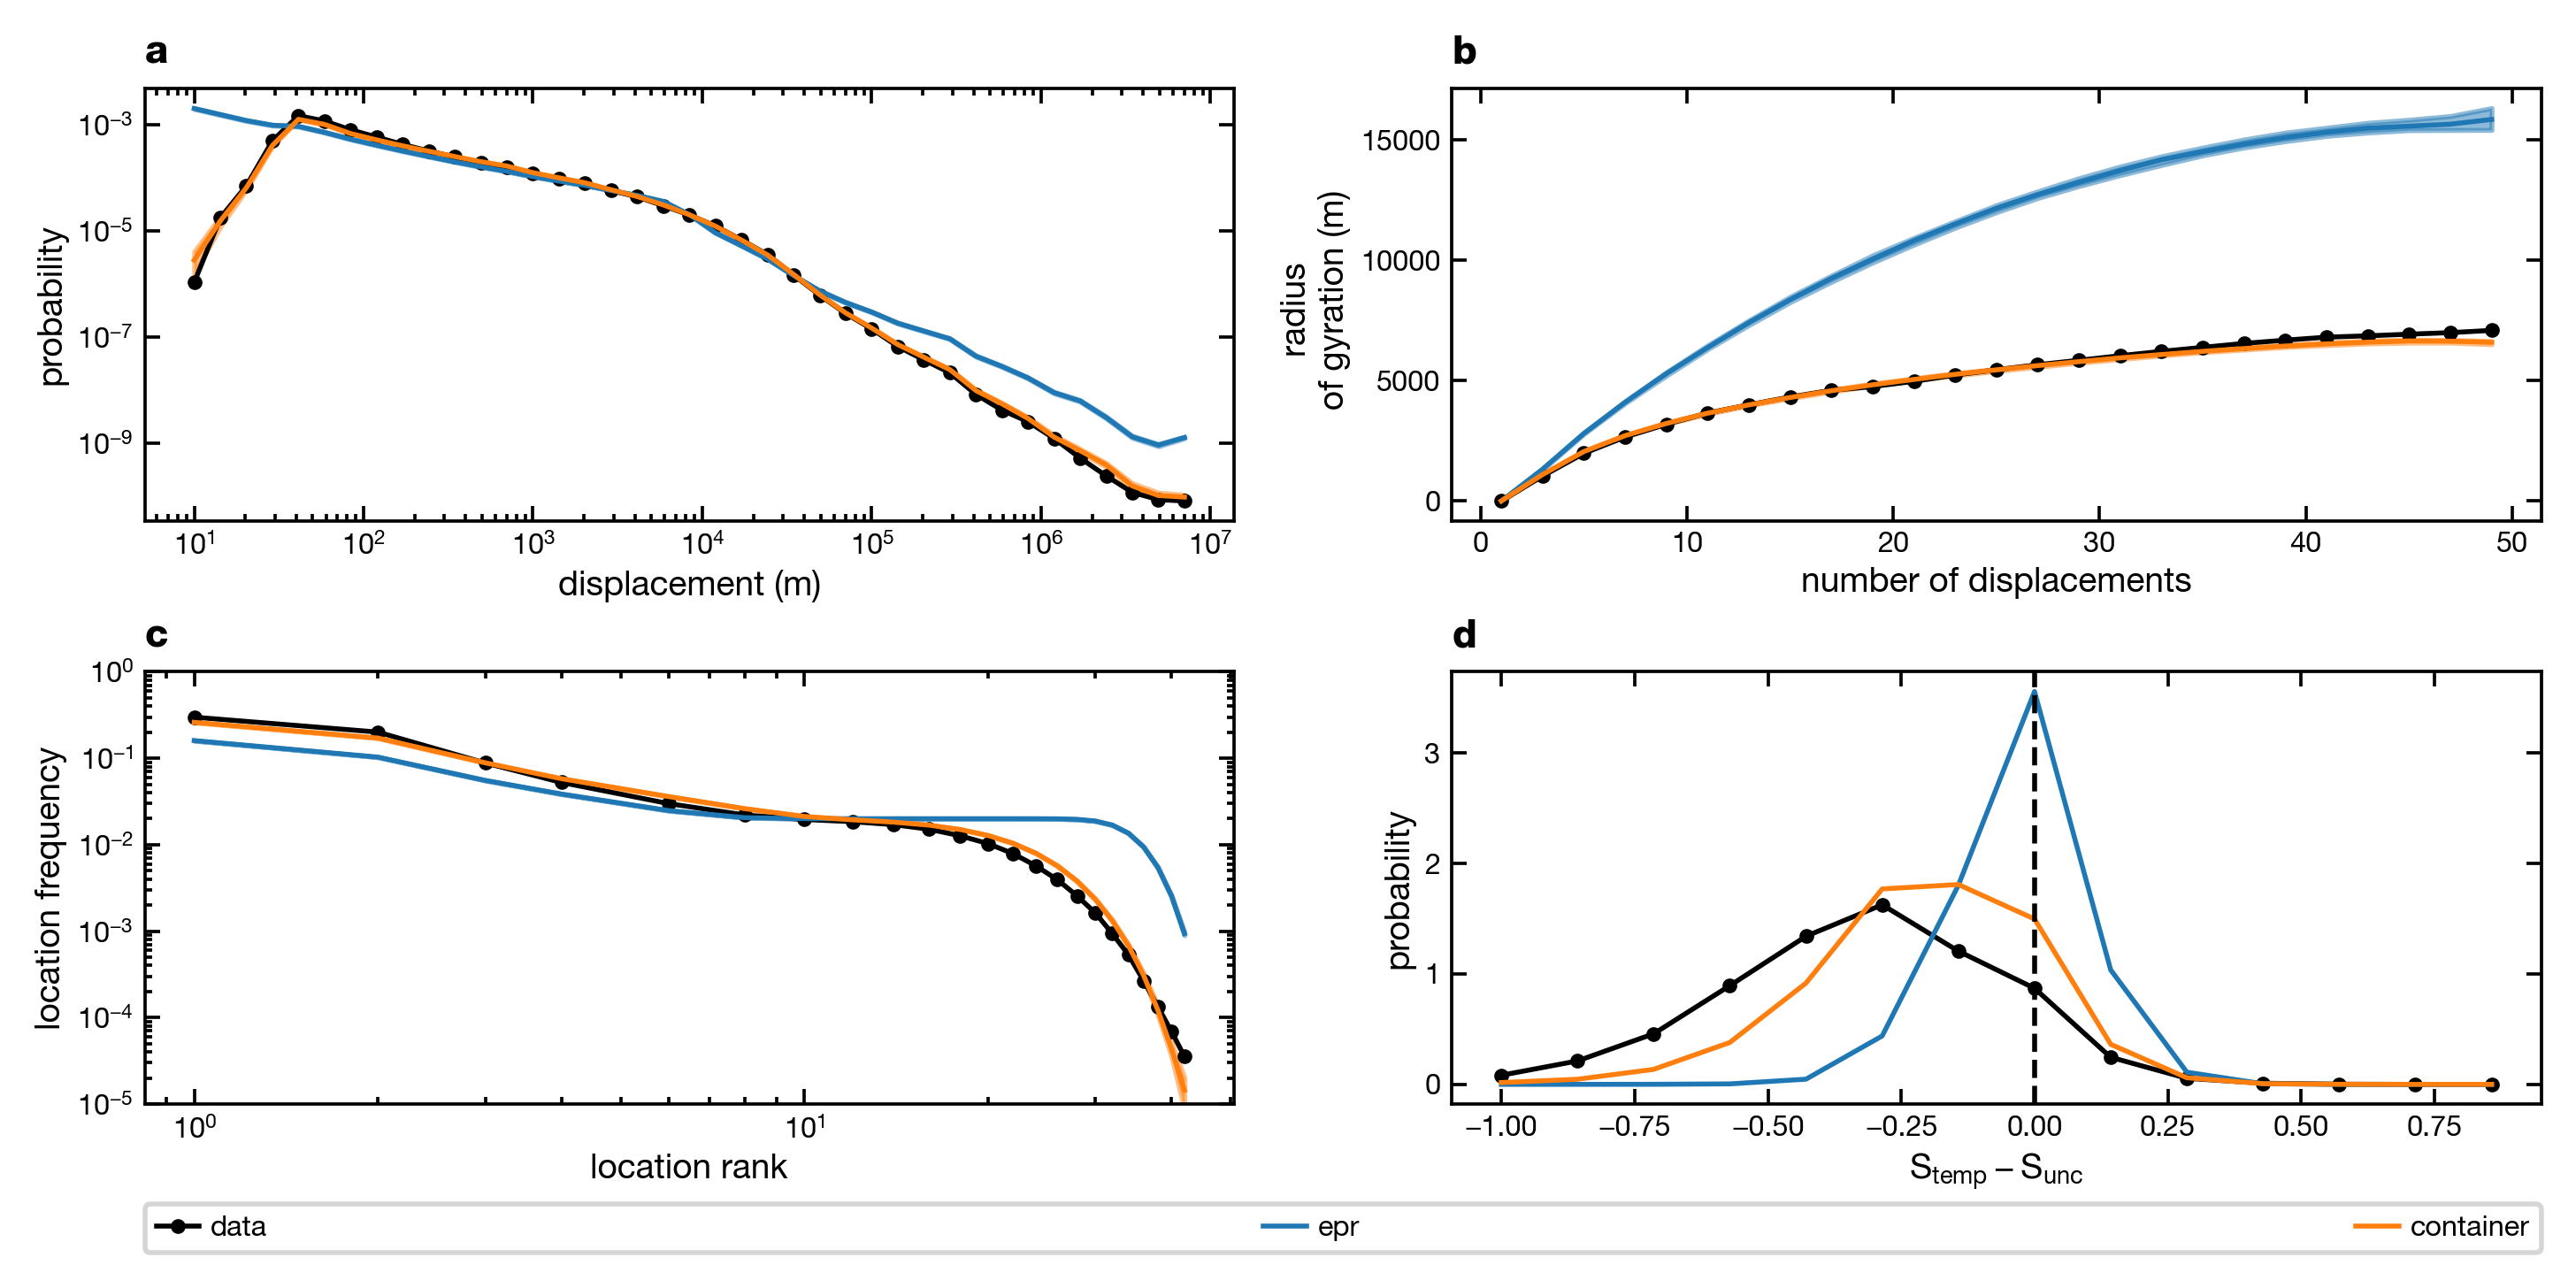

In [8]:
fig, axes = plt.subplots(2,2, figsize = (3.60236*2,3.5))
plt.subplots_adjust(hspace = 0.35,left=0.05,right=0.99,top=0.95,bottom=0.13)#, wspace = 0.35, right = 0.98, left = 0.1, bottom = 0.35, top = 0.9)

ax = axes.flatten()

x_1,y_1,sim_1,errs_1 = plot_distr_displacements(ax[0],props[:2],errs[:2],properties_testing)
x_2, y_2,sim_2,errs_2, errs_2_2 = plot_radius_of_gyration(ax[1],props[:2],errs[:2],properties_testing)
x_3,y_3,sim_3,errs_3 = plot_frequency_rank(ax[2],props[:2],errs[:2],properties_testing)
x_4,y_4,sim_4, = plot_entropy(ax[3],props[:2],errs[:2],properties_testing,labels)



x1 =  ax[0].get_position().get_points()[0][0]
x2 =  ax[-1].get_position().get_points()[0][0]
x3 =  ax[-1].get_position().get_points()[1][0]


y1 = ax[0].get_position().get_points()[-1][1]+0.02
y2 = ax[2].get_position().get_points()[-1][1]+0.02

letters = ['a','c','b','d']
positions = [x1,x1,x2,x2]
positions2 = [y1,y2,y1,y2]
for n,a in enumerate(ax):
    a.text(positions[n], positions2[n], 
           letters[n], 
           transform=fig.transFigure, 
           fontsize = 8, 
           weight="bold", 
           fontdict={ 'family':'Helvetica 65 Medium'} )

#SAVE


lgd = plt.figlegend(ncol = 3,
                    handlelength=1.5,
                    handletextpad=0.4,
                    bbox_transform = fig.transFigure,
                    loc = 'lower center',
                    mode = 'expand',
                    bbox_to_anchor=(x1,0.01,x3-x1,0.1),
                    borderaxespad=0)
#fig.legend(mode = 'expand', ncol = 3, bbox_to_anchor=(0.09 ,0.15 ,0.9, 0.05))

#plt.savefig("../outputs/Figure2/Figure2.svg",dpi=600)
#plt.savefig("../outputs/Figure2/Figure2.pdf",dpi=600)



In [55]:
len(x),len(std), len(rg)

(50, 50, 50)

In [147]:
#Log growth
x = range(1,50)
mean_rgs = []
std_rgs = []

rg_data= np.nanmedian([list(i[1])+[np.nan]*(50-len(i[1])) for n,i in enumerate(properties_testing) if len(properties_testing[n][1])>0],axis = 0)[1:]
rg_err1 = np.nanpercentile([list(i[1])+[np.nan]*(50-len(i[1])) for n,i in enumerate(p) if len(err_p[n][1])>0],25, axis = 0)[1:]
rg_err2 = np.nanpercentile([list(i[1])+[np.nan]*(50-len(i[2])) for n,i in enumerate(p) if len(err_p[n][2])>0],75, axis = 0)[1:]

for p,err_p in zip(props,errs):

    rg = np.nanmedian([list(i[1])+[np.nan]*(50-len(i[1])) for n,i in enumerate(p) if len(p[n][1])>0],axis = 0)
    rg_err1 = np.nanpercentile([list(i[1])+[np.nan]*(50-len(i[1])) for n,i in enumerate(p) if len(err_p[n][1])>0],25, axis = 0)
    rg_err2 = np.nanpercentile([list(i[1])+[np.nan]*(50-len(i[2])) for n,i in enumerate(p) if len(err_p[n][2])>0],75, axis = 0)

    mean_rgs.append(rg[1:])
    std_rgs.append(rg_err1[1:])

(a,b), err_ = scipy.optimize.curve_fit(lambda t,a,b: a+b*np.log(t),    x,  rg_data)

(a2,b2), err_2 = scipy.optimize.curve_fit(lambda t,a,b: a+b*np.log(t), x,mean_rgs[0],
                                          sigma = std_rgs[0], absolute_sigma = True)
(a3,b3), err_3 = scipy.optimize.curve_fit(lambda t,a,b: a+b*np.log(t), x, mean_rgs[1],
                                         sigma = std_rgs[1], absolute_sigma = True)


err_ = np.sqrt(np.diag(err_))
err_2 = np.sqrt(np.diag(err_2))
err_3 = np.sqrt(np.diag(err_3))


In [148]:
print(a+err_[0], a-err_[0])
print(b+err_[1], b-err_[1], b, err_[1])

-334.36764790941925 -634.645101590799
1956.9062083572462 1859.3626333381217 1908.134420847684 48.77178750956221


In [149]:
print(a2+err_2[0], a2-err_2[0])#, a2, err_2[0])
print(b2+err_2[0], b2-err_2[0], b2, err_2[1])

779.0563028082064 -286.5303937756561
3562.3086549952754 2496.721958411413 3029.5153067033443 531.5312667505127


In [150]:
print(a3+err_3[0], a3-err_3[0])#, a3, err_3[0])
print(b3+err_3[0], b3-err_3[0], b3, err_3[1])

1180.0159094501703 -271.3181690475435
2222.815283170118 771.4812046724045 1497.1482439212614 371.74125417353775


In [ ]:
import scipy
#Log growth

median_rg_data = y_2
median_rg_scales = sim_2[1]
median_rg_scales_err = zip(errs_2[1], errs_2_2[1])

median_rg_epr = sim_2[0]
median_rg_epr_err = zip(errs_2[0], errs_2_2[0])

(a,b), err_ = scipy.optimize.curve_fit(lambda t,a,b: a+b*np.log(t),    x_2,  list(median_rg_data))
(a2,b2), err_2 = scipy.optimize.curve_fit(lambda t,a,b: a+b*np.log(t), x_2, list(median_rg_scales),sigma = np.array(list(median_rg_scales_err)), absolute_sigma = True)
(a3,b3), err_3 = scipy.optimize.curve_fit(lambda t,a,b: a+b*np.log(t), x_2,   list(median_rg_epr), sigma = np.array(list(median_rg_epr_err)), absolute_sigma = True)


err_ = np.sqrt(np.diag(err_))
err_2 = np.sqrt(np.diag(err_2))
err_3 = np.sqrt(np.diag(err_3))

In [39]:
scipy.optimize.curve_fit??

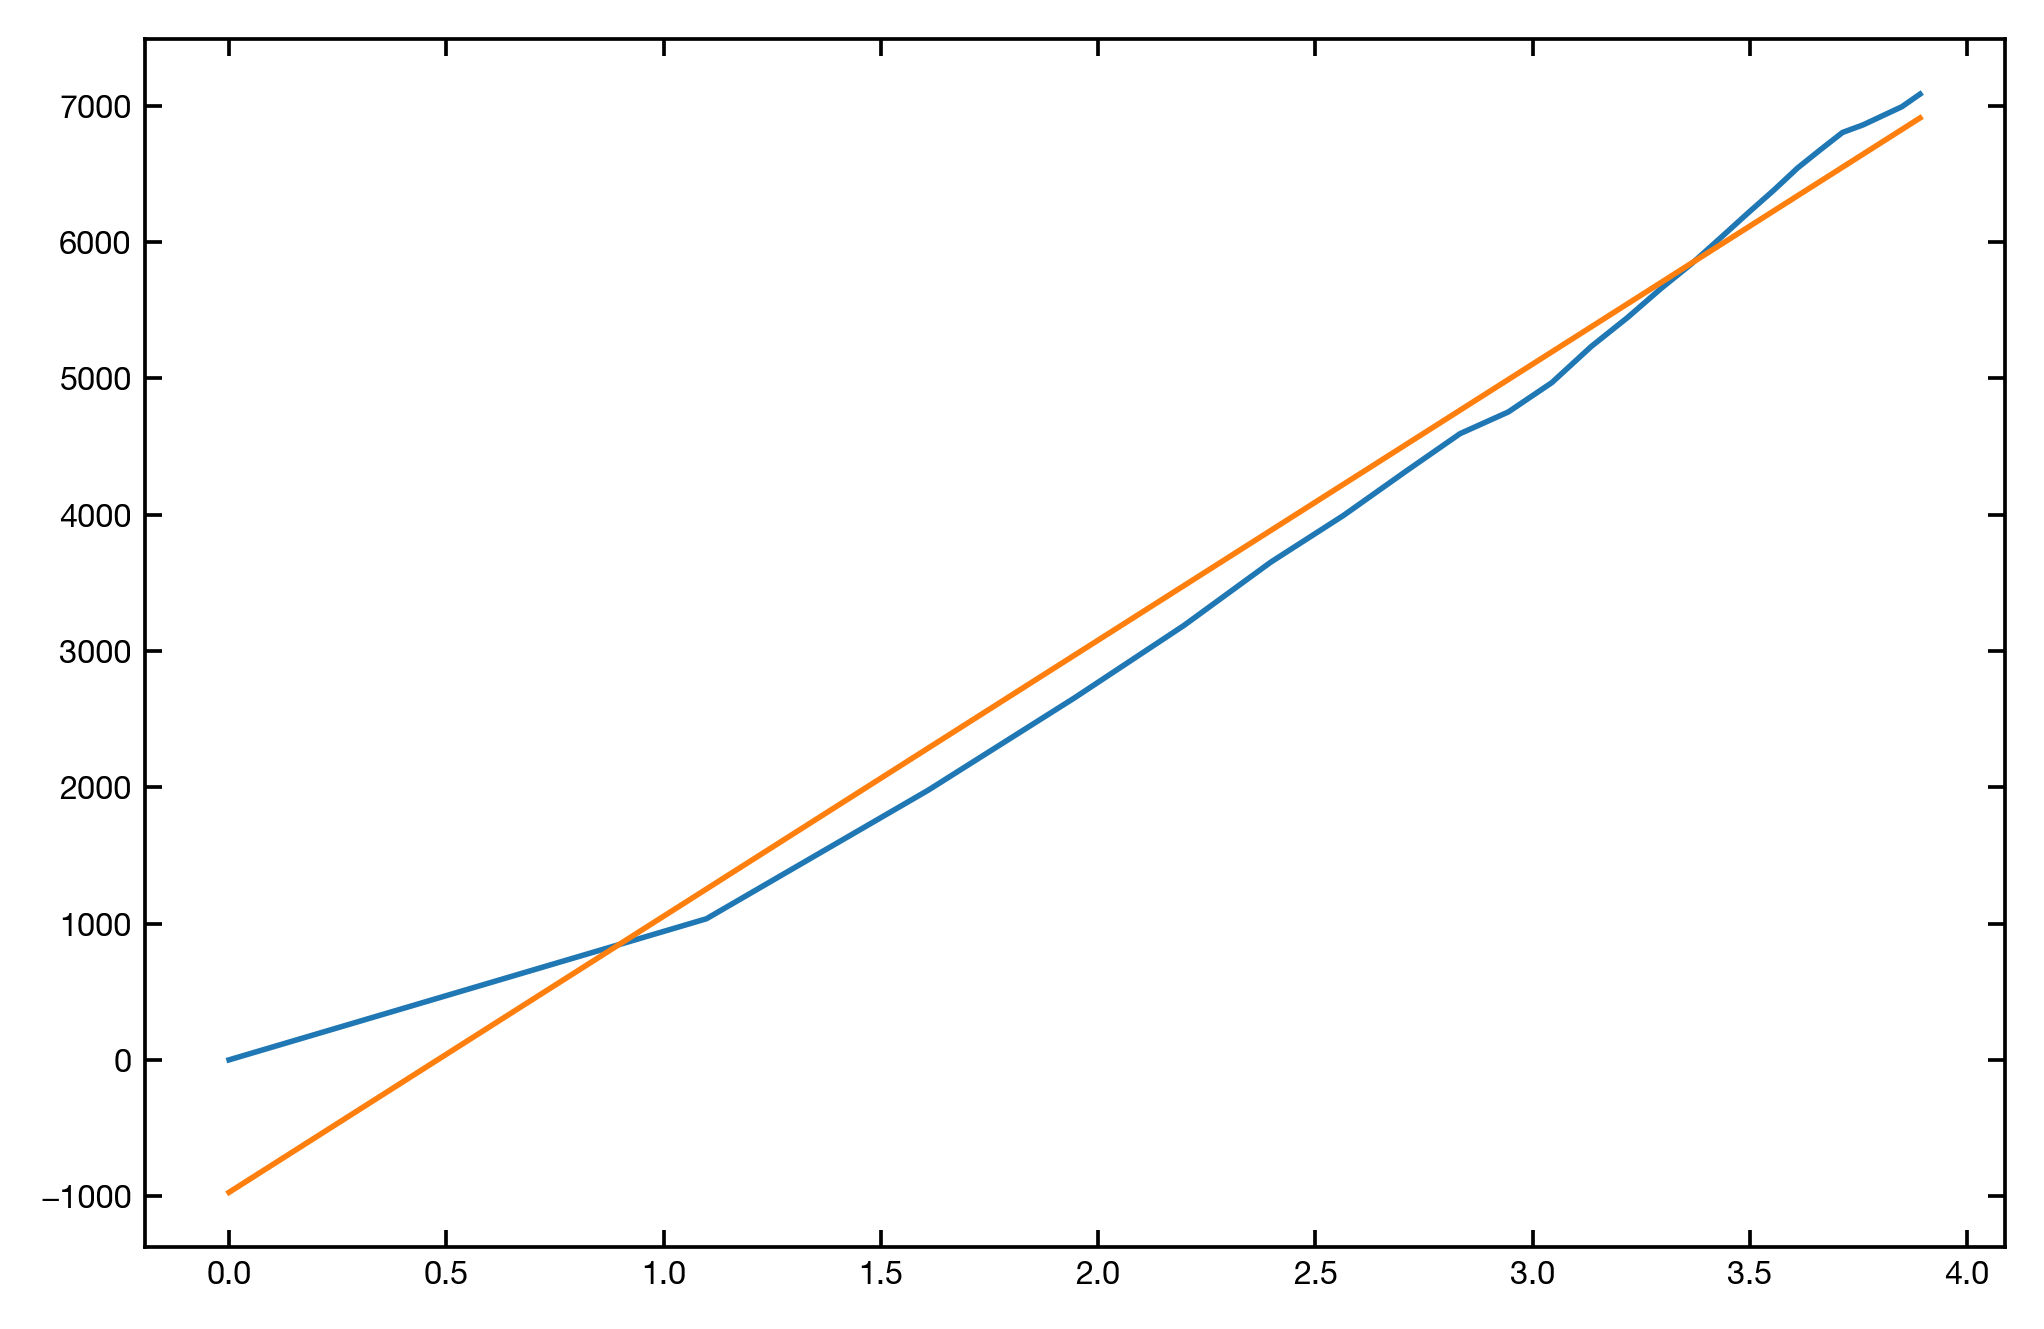

In [32]:
plt.plot(np.log(x_2),y_2)
a,b = res.params
plt.plot(np.log(x_2),[a+b*i for i in np.log(x_2)])

In [10]:
panel_a = pd.DataFrame([x_1,y_1,sim_1[0],sim_1[1],errs_1[0],errs_1[1]],
            index = ['x','data','epr_mean','scales_mean','std_epr','std_scales']).T.to_pickle("../outputs/Figure2/panel_a.pkl",protocol=4)
panel_b = pd.DataFrame([x_2,y_2,sim_2[0],sim_2[1],errs_2[0],errs_2[1], errs_2_2[0],errs_2_2[1]],
            index = ['x','data','epr_median','scales_median','epr_25_perc','scales_25_perc',
                    'epr_75_perc','scales_75_perc']).T.to_pickle("../outputs/Figure2/panel_b.pkl",protocol=4)
panel_c = pd.DataFrame([x_3,y_3,sim_3[0],sim_3[1],errs_3[0],errs_3[1]],
            index = ['x','data','epr_mean','scales_mean','std_epr','std_scales']).T.to_pickle("../outputs/Figure2/panel_c.pkl",protocol=4)

panel_d = pd.DataFrame([x_4,y_4,sim_4[0],sim_4[1]],
            index = ['x','data','y_epr','y_scales']).T.to_pickle("../outputs/Figure2/panel_d.pkl",protocol=4)

In [15]:
pd.DataFrame([x_2,y_2,sim_2[0],sim_2[1],errs_2[0],errs_2[1], errs_2_2[0],errs_2_2[1]],
            index = ['x','data','epr_median','scales_median','epr_25_perc','scales_25_perc',
                    'epr_75_perc','scales_75_perc']).T

,x,data,epr_median,scales_median,epr_25_perc,scales_25_perc,epr_75_perc,scales_75_perc
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.0,1034.732687,1319.106470,1097.409424,1300.540102,1081.491048,1337.082913,1110.871033
2,5.0,1978.502238,2801.384875,2052.598047,2781.654930,2035.602441,2837.960096,2072.331836
3,7.0,2655.262334,4097.351695,2712.867188,4056.714499,2688.167585,4138.617927,2730.163993
4,9.0,3185.152446,5287.584194,3218.867405,5205.953584,3196.992974,5345.182330,3253.506049
5,11.0,3651.214636,6370.327875,3645.527876,6303.383550,3612.010698,6459.765546,3670.852628
6,13.0,3993.152814,7409.065362,3991.527194,7304.879298,3961.887846,7498.648843,4019.997296
7,15.0,4316.053052,8363.633436,4296.629036,8259.779312,4264.461947,8479.710277,4338.152962
8,17.0,4593.084336,9249.640303,4578.137293,9101.410015,4537.415384,9357.509948,4621.473231
9,19.0,4752.300713,10043.727710,4824.179482,9901.573485,4787.703845,10202.517646,4869.578742


In [62]:
panel_a = pd.DataFrame([x_1,y_1,sim_1[0],sim_1[1],errs_1[0],errs_1[1]],
            index = ['x','data','epr_mean','scales_mean','std_epr','std_scales']).T.to_csv("../outputs/Figure2/panel_a_source.csv",index=False)
panel_b = pd.DataFrame([x_2,y_2,sim_2[0],sim_2[1],errs_2[0],errs_2[1], errs_2_2[0],errs_2_2[1]],
            index = ['x','data','epr_median','scales_median','epr_25_perc','scales_25_perc',
                    'epr_75_perc','scales_75_perc']).T.to_csv("../outputs/Figure2/panel_b_source.csv",index=False)
panel_c = pd.DataFrame([x_3,y_3,sim_3[0],sim_3[1],errs_3[0],errs_3[1]],
            index = ['x','data','epr_mean','scales_mean','std_epr','std_scales']).T.to_csv("../outputs/Figure2/panel_c_source.csv",index=False)

panel_d = pd.DataFrame([x_4,y_4,sim_4[0],sim_4[1]],
            index = ['x','data','y_epr','y_scales']).T.to_csv("../outputs/Figure2/panel_d_source.csv",index=False)

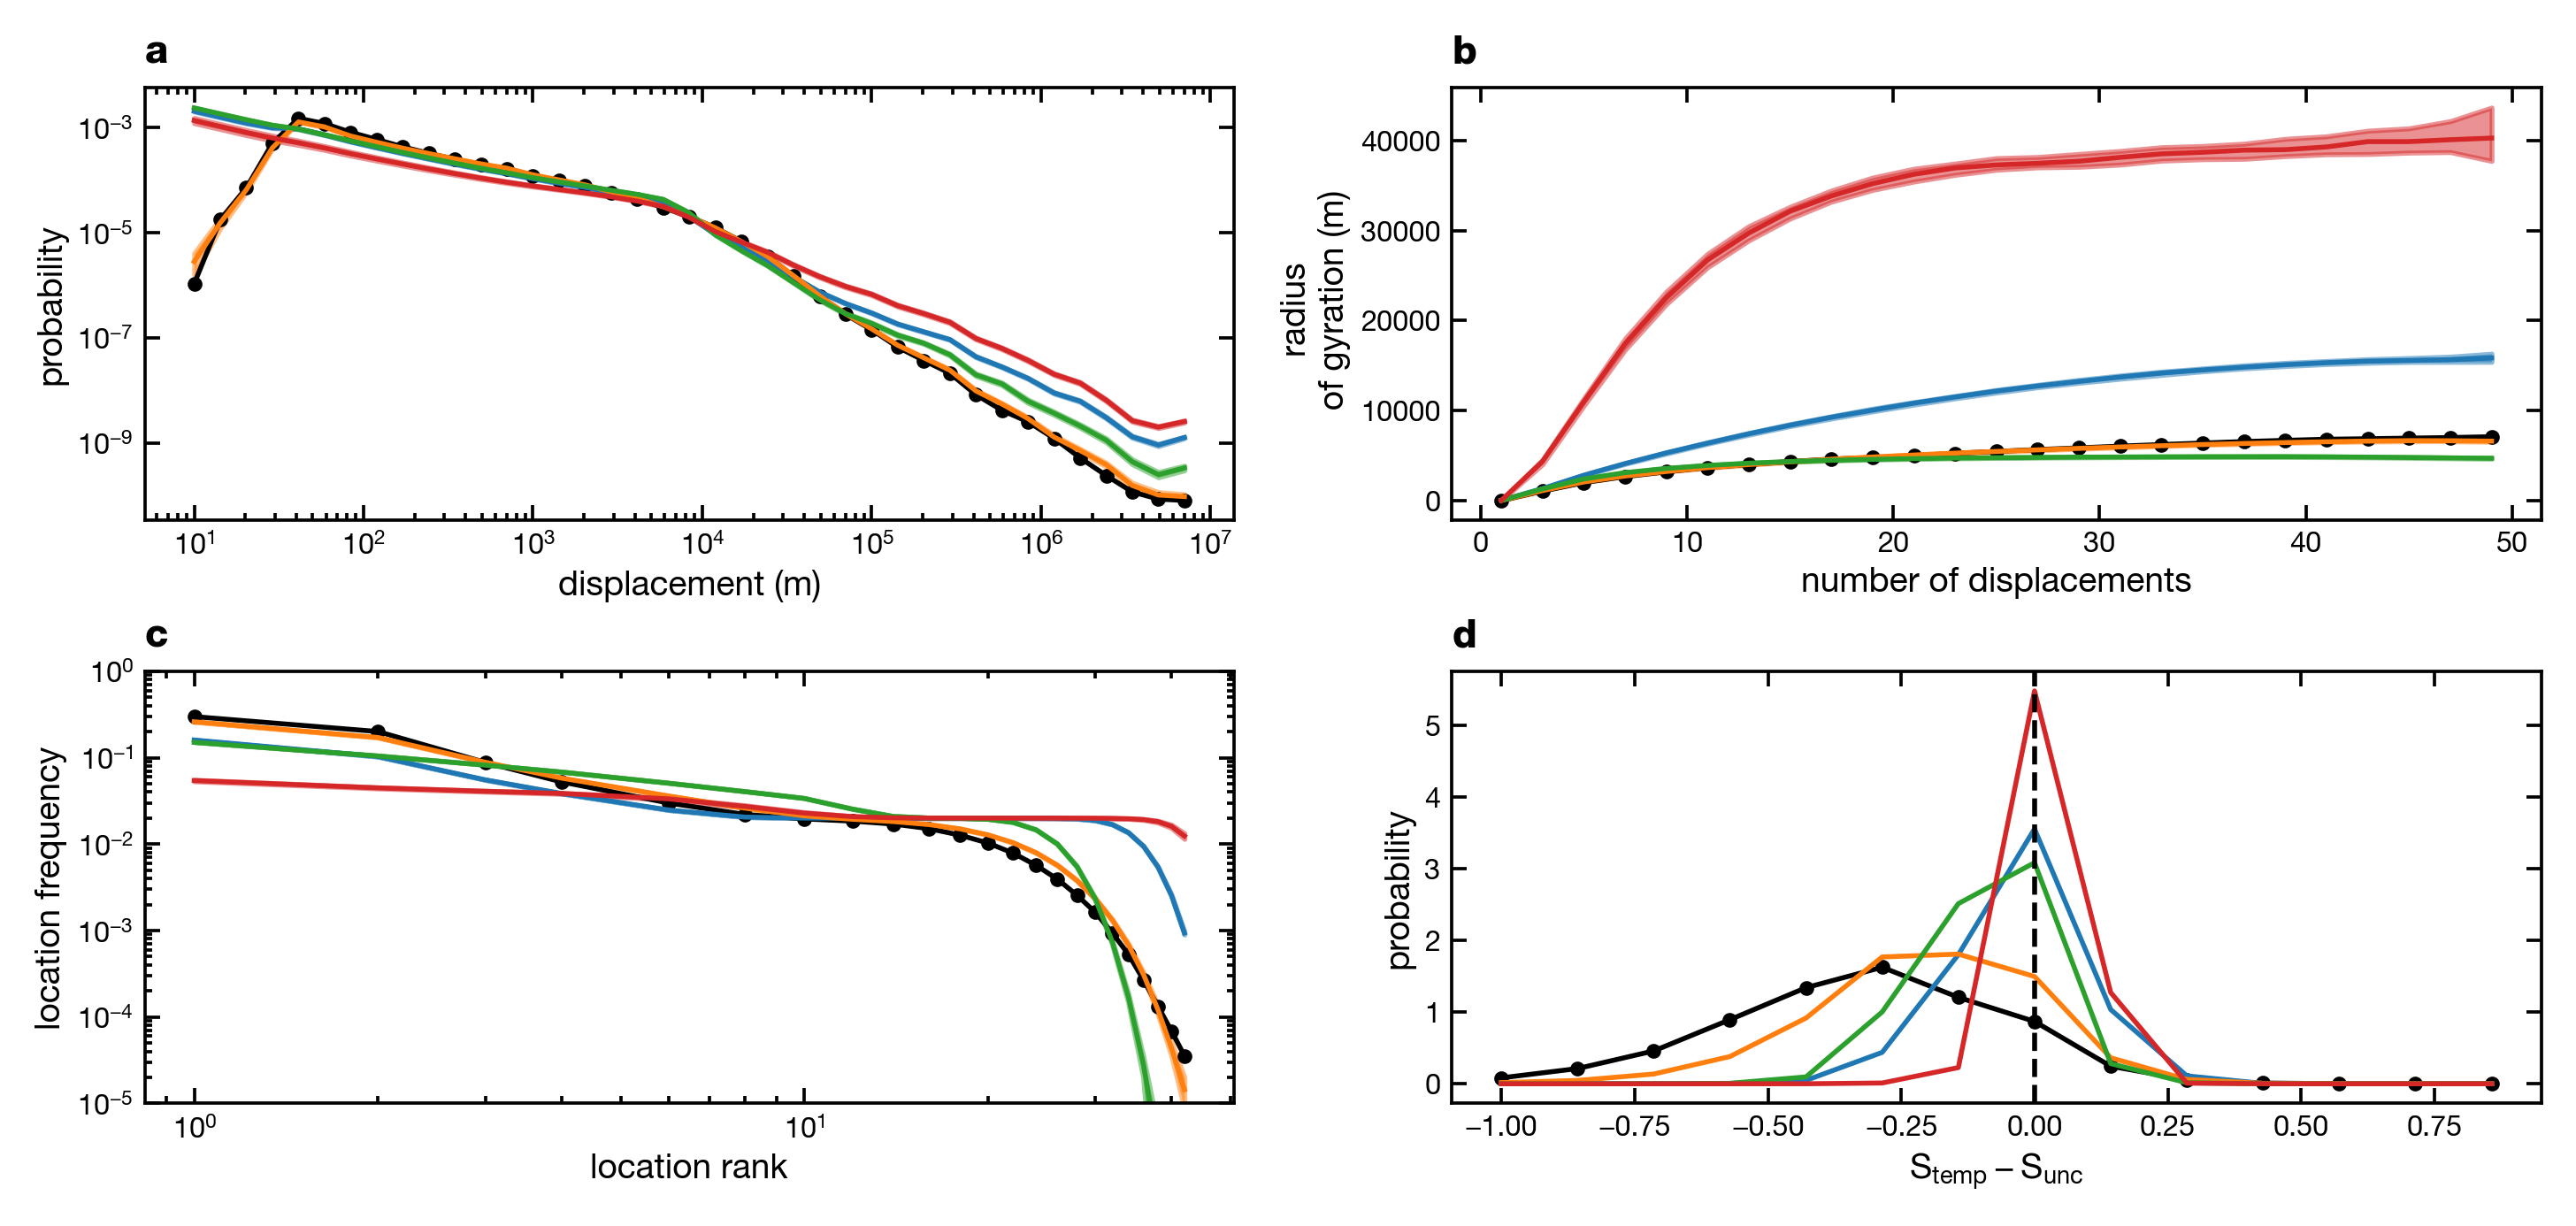

In [64]:
fig, axes = plt.subplots(2,2, figsize = (3.60236*2,3.5))
plt.subplots_adjust(hspace = 0.35,left=0.05,right=0.99,top=0.95,bottom=0.13)#, wspace = 0.35, right = 0.98, left = 0.1, bottom = 0.35, top = 0.9)

ax = axes.flatten()

plot_distr_displacements(ax[0],props,errs,properties_testing)
plot_radius_of_gyration(ax[1],props,errs,properties_testing)
plot_frequency_rank(ax[2],props,errs,properties_testing)
plot_entropy(ax[3],props,errs,properties_testing,labels)



x1 =  ax[0].get_position().get_points()[0][0]
x2 =  ax[-1].get_position().get_points()[0][0]
x3 =  ax[-1].get_position().get_points()[1][0]


y1 = ax[0].get_position().get_points()[-1][1]+0.02
y2 = ax[2].get_position().get_points()[-1][1]+0.02

letters = ['a','c','b','d']
positions = [x1,x1,x2,x2]
positions2 = [y1,y2,y1,y2]
for n,a in enumerate(ax):
    a.text(positions[n], positions2[n], 
           letters[n], 
           transform=fig.transFigure, 
           fontsize = 8, 
           weight="bold", 
           fontdict={ 'family':'Helvetica 65 Medium'} )

#SAVE



#fig.legend(mode = 'expand', ncol = 3, bbox_to_anchor=(0.09 ,0.15 ,0.9, 0.05))

plt.savefig("../outputs/Extended_data/Extended_data_7_a_d.pdf",dpi=600)
plt.savefig("../outputs/Extended_data/Extended_data_7_a_d.svg",dpi=600)